In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import normalize
import SimpleITK as sitk
import numpy as np
import os
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

### Voxel classification under/overestimation confusion matrix

In [2]:
# test_or_validation = "test"
test_or_validation = "validation"

In [3]:
def create_averaged_confusion_matrix(dataset,
                                     output_shape,
                                     include_background_classification=True):
    if dataset not in os.listdir(f"./contours_compare_{test_or_validation}"):
        print(f"Data for {dataset} not found")
        return
    
    path_to_evaluation_data = f"./contours_compare_{test_or_validation}/{dataset}"
    path_to_ground_truths = f"{path_to_evaluation_data}/ground_truth"
    path_to_model_predictions = f"{path_to_evaluation_data}/model_output"
    path_to_prostate_delineations = f"{path_to_evaluation_data}/downscaled_prostate_delineations"
    
    # (4, 4) if you want to include background classifications and predictions
    output_cm = np.zeros(output_shape)

    if output_cm.shape == (4, 4):
        voxel_labels = [0, 1, 2, 3]
    elif output_cm.shape == (3, 3):
        voxel_labels = [0, 1, 2]
    elif output_cm.shape == (2, 2):
        voxel_labels = [0, 1]
    else:
        print("Gave invalid shape ", output_shape)
        print("Supported = (3, 3) & (4, 4)")
        return

    num_cases = len(os.listdir(path_to_model_predictions))

    print(f"Creating confusion matrix for {dataset}")
    for patient_file in tqdm(os.listdir(path_to_model_predictions)):
        if ".nii.gz" in patient_file:
            # print(patient_file[:10])
            gt = sitk.ReadImage(f"{path_to_ground_truths}/{patient_file}")
            mp = sitk.ReadImage(f"{path_to_model_predictions}/{patient_file}")
            prostate_delin = sitk.ReadImage(f"{path_to_prostate_delineations}/{patient_file}")

            gt = sitk.GetArrayFromImage(gt)
            mp = sitk.GetArrayFromImage(mp)
            prostate_delin = sitk.GetArrayFromImage(prostate_delin)

            gt = gt.flatten()
            mp = mp.flatten()
            prostate_delin = prostate_delin.flatten()

            # Only count voxels in the prostate to prevent bloating of background
            # Use only voxels that are classified as prostate in the prostate delineation
            gt = gt[prostate_delin != 0]
            mp = mp[prostate_delin != 0]

            cm = confusion_matrix(gt, mp, labels = voxel_labels)
            
            output_cm += cm

    print("sum of confusion matrices, voxelwise: \n", output_cm.astype(int))
    print("total number of cases:", num_cases)
    output_cm = output_cm/num_cases

    return output_cm

all_modalities_cm = create_averaged_confusion_matrix("Dataset005_pca", (4, 4))
gg3gg4_combined_cm = create_averaged_confusion_matrix("Dataset006_pca_gg3gg4combined", (3, 3))
cribriform_only_cm = create_averaged_confusion_matrix("Dataset007_pca_cribriform_only", (2, 2))
adc_only_cm = create_averaged_confusion_matrix("Dataset008_pcaadc", (4, 4))
perf_only_cm = create_averaged_confusion_matrix("Dataset009_pcaperf", (4, 4))




Creating confusion matrix for Dataset005_pca


100%|██████████| 43/43 [00:07<00:00,  5.84it/s]


sum of confusion matrices, voxelwise: 
 [[2725639   16865   31790     220]
 [  52098   19055   35298     401]
 [  31281   12271   52312     147]
 [   5692    2227   10847      69]]
total number of cases: 43
Creating confusion matrix for Dataset006_pca_gg3gg4combined


100%|██████████| 43/43 [00:06<00:00,  6.34it/s]


sum of confusion matrices, voxelwise: 
 [[2713639   60875       0]
 [  68486  134315      62]
 [   4970   13865       0]]
total number of cases: 43
Creating confusion matrix for Dataset007_pca_cribriform_only


100%|██████████| 43/43 [00:06<00:00,  6.30it/s]


sum of confusion matrices, voxelwise: 
 [[2977377       0]
 [  18835       0]]
total number of cases: 43
Creating confusion matrix for Dataset008_pcaadc


100%|██████████| 43/43 [00:06<00:00,  6.35it/s]


sum of confusion matrices, voxelwise: 
 [[2734517   19428   20361     208]
 [  54222   17226   35135     269]
 [  34141   23535   38166     169]
 [   6587    1648   10381     219]]
total number of cases: 43
Creating confusion matrix for Dataset009_pcaperf


100%|██████████| 43/43 [00:06<00:00,  6.45it/s]

sum of confusion matrices, voxelwise: 
 [[2701462   37281   35536     235]
 [  62134   15769   28948       1]
 [  38641   12903   44467       0]
 [   6298    5887    6650       0]]
total number of cases: 43


In [8]:
# Foreground/background
# #################################################################
def create_averaged_confusion_matrix_foreground_background(dataset):
    if dataset not in os.listdir(f"./contours_compare_{test_or_validation}"):
        print(f"Data for {dataset} not found")
        return

    path_to_evaluation_data = f"./contours_compare_{test_or_validation}/{dataset}"
    path_to_ground_truths = f"{path_to_evaluation_data}/ground_truth"
    path_to_model_predictions = f"{path_to_evaluation_data}/model_output"
    path_to_prostate_delineations = f"{path_to_evaluation_data}/downscaled_prostate_delineations"
    
    # output is always of shape (2, 2) as there is only distinguishing between foreground and background
    output_cm = np.zeros((2, 2))

    num_cases = len(os.listdir(path_to_model_predictions))

    print(f"Creating cm for {dataset}")
    for patient_file in tqdm(os.listdir(path_to_model_predictions)):
        if ".nii.gz" in patient_file:
            # print(patient_file[:10])
            gt = sitk.ReadImage(f"{path_to_ground_truths}/{patient_file}")
            mp = sitk.ReadImage(f"{path_to_model_predictions}/{patient_file}")
            prostate_delin = sitk.ReadImage(f"{path_to_prostate_delineations}/{patient_file}")

            gt = sitk.GetArrayFromImage(gt)
            mp = sitk.GetArrayFromImage(mp)
            prostate_delin = sitk.GetArrayFromImage(prostate_delin)
            
            gt = gt.flatten()
            mp = mp.flatten()
            prostate_delin = prostate_delin.flatten()

            # Only count voxels in the prostate to prevent bloating of background
            # Use only voxels that are classified as prostate in the prostate delineation
            gt = gt[prostate_delin != 0]
            mp = mp[prostate_delin != 0]

            # Transform both delineations in to binary ones, distinguishing only
            # between foreground (lesion) and background (no lesion)
            gt = np.where(gt != 0, 1, 0)
            mp = np.where(mp != 0, 1, 0)

            cm = confusion_matrix(gt, mp, labels=[0, 1])
            
            output_cm += cm

    print("total number of cases:", num_cases)
    print("final cm : \n", output_cm)
    output_cm = output_cm/num_cases
    print("final cm averaged over patients: \n", output_cm)
    print()

    return output_cm

all_modalities_cm_foreground_background = create_averaged_confusion_matrix_foreground_background("Dataset005_pca")
gg3gg4_combined_cm_foreground_background = create_averaged_confusion_matrix_foreground_background("Dataset006_pca_gg3gg4combined")
cribriform_only_cm_foreground_background = create_averaged_confusion_matrix_foreground_background("Dataset007_pca_cribriform_only")
adc_only_cm_foreground_background = create_averaged_confusion_matrix_foreground_background("Dataset008_pcaadc")
perf_only_cm_foreground_background = create_averaged_confusion_matrix_foreground_background("Dataset009_pcaperf")

Creating cm for Dataset005_pca


  0%|          | 0/43 [00:00<?, ?it/s]

100%|██████████| 43/43 [00:06<00:00,  6.65it/s]


total number of cases: 43
final cm : 
 [[2725639.   48875.]
 [  89071.  132627.]]
final cm averaged over patients: 
 [[63386.95348837  1136.62790698]
 [ 2071.41860465  3084.34883721]]

Creating cm for Dataset006_pca_gg3gg4combined


100%|██████████| 43/43 [00:06<00:00,  6.86it/s]


total number of cases: 43
final cm : 
 [[2713639.   60875.]
 [  73456.  148242.]]
final cm averaged over patients: 
 [[63107.88372093  1415.69767442]
 [ 1708.27906977  3447.48837209]]

Creating cm for Dataset007_pca_cribriform_only


100%|██████████| 43/43 [00:06<00:00,  6.91it/s]


total number of cases: 43
final cm : 
 [[2977377.       0.]
 [  18835.       0.]]
final cm averaged over patients: 
 [[69241.3255814      0.        ]
 [  438.02325581     0.        ]]

Creating cm for Dataset008_pcaadc


100%|██████████| 43/43 [00:06<00:00,  6.66it/s]


total number of cases: 43
final cm : 
 [[2734517.   39997.]
 [  94950.  126748.]]
final cm averaged over patients: 
 [[63593.41860465   930.1627907 ]
 [ 2208.13953488  2947.62790698]]

Creating cm for Dataset009_pcaperf


100%|██████████| 43/43 [00:06<00:00,  6.58it/s]

total number of cases: 43
final cm : 
 [[2701462.   73052.]
 [ 107073.  114625.]]
final cm averaged over patients: 
 [[62824.69767442  1698.88372093]
 [ 2490.06976744  2665.69767442]]



In [5]:
# Function to row-wise normalize a confusion matrix and return a set of labels suitable for plotting
# The labels, for each cell (equal shape to input cm), are the normalized value and the original (integer) count
def normalize_and_create_annotations(cm):
    normalized_cm = normalize(cm, axis = 1, norm = 'l1').round(3)

    labels = np.empty(cm.shape, dtype = object)

    for i, row in enumerate(cm):
        for j, col in enumerate(cm):
            labels[i, j] = f"{normalized_cm[i][j]}\n ({int(cm[i][j])})"

    return normalized_cm, labels


In [6]:
# cms
all_modalities_cm
gg3gg4_combined_cm
cribriform_only_cm
adc_only_cm
perf_only_cm
all_modalities_cm_foreground_background
gg3gg4_combined_cm_foreground_background
cribriform_only_cm_foreground_background
adc_only_cm_foreground_background
perf_only_cm_foreground_background

array([[62824.69767442,  1698.88372093],
       [ 2490.06976744,  2665.69767442]])

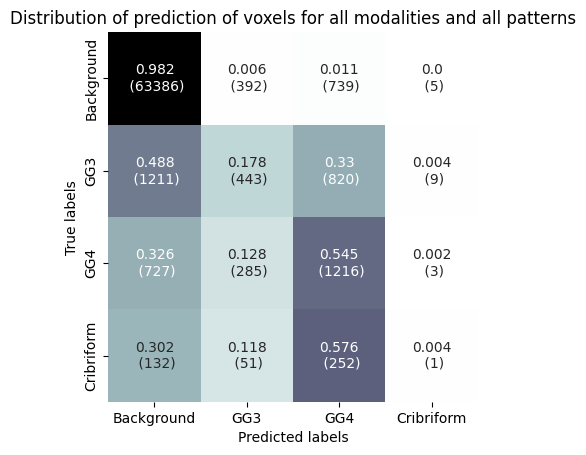

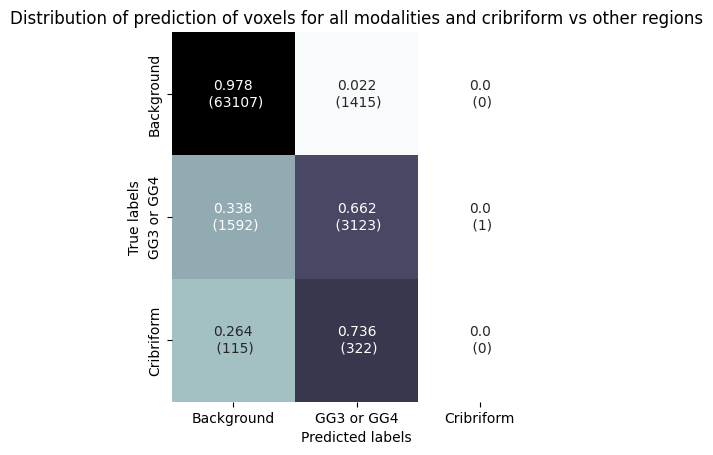

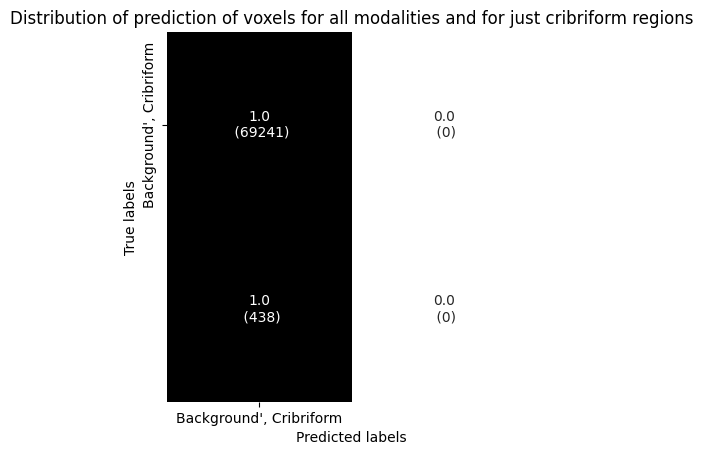

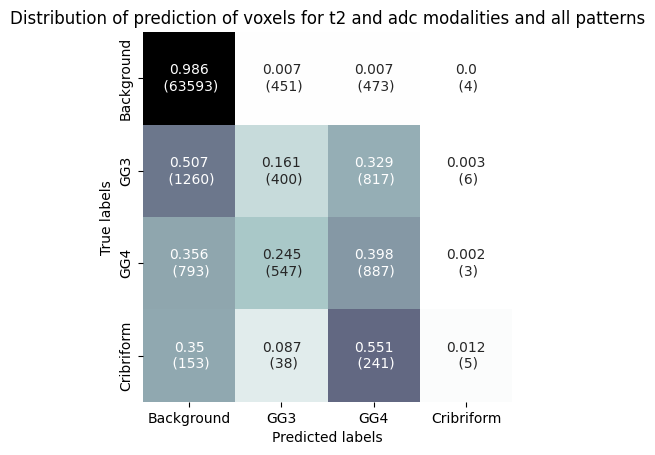

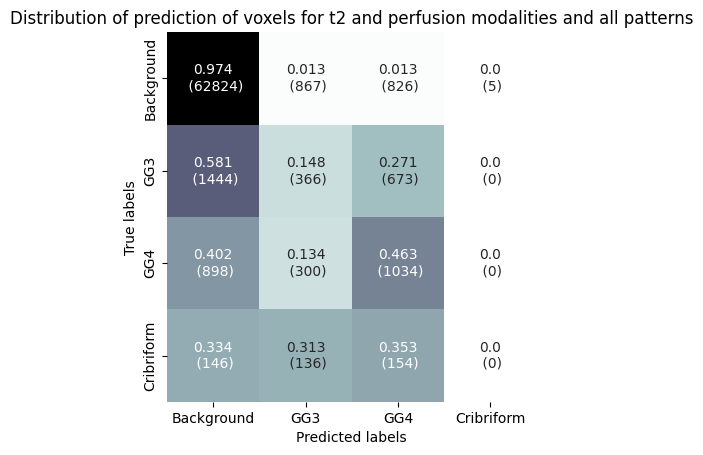

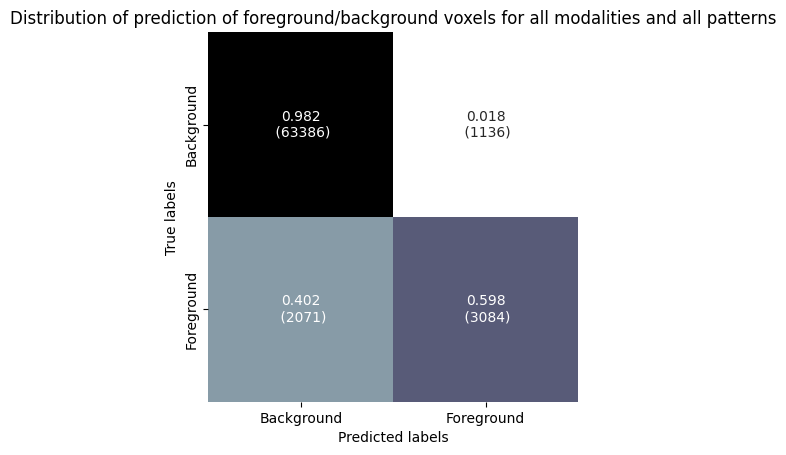

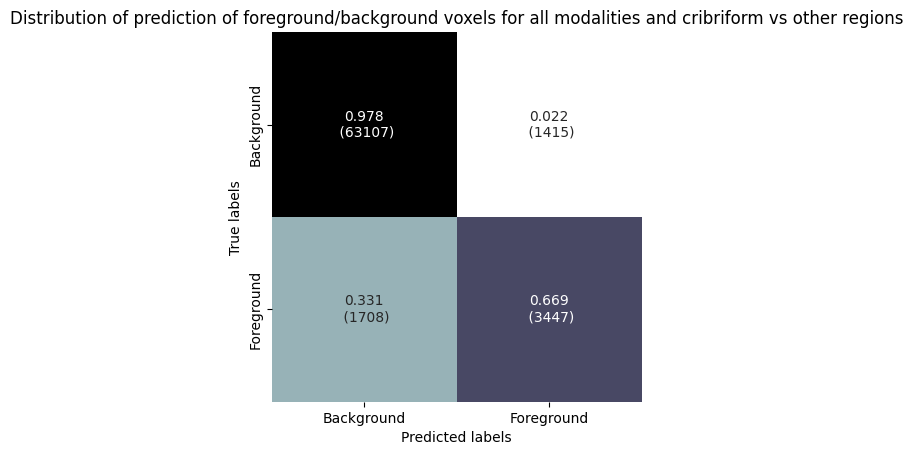

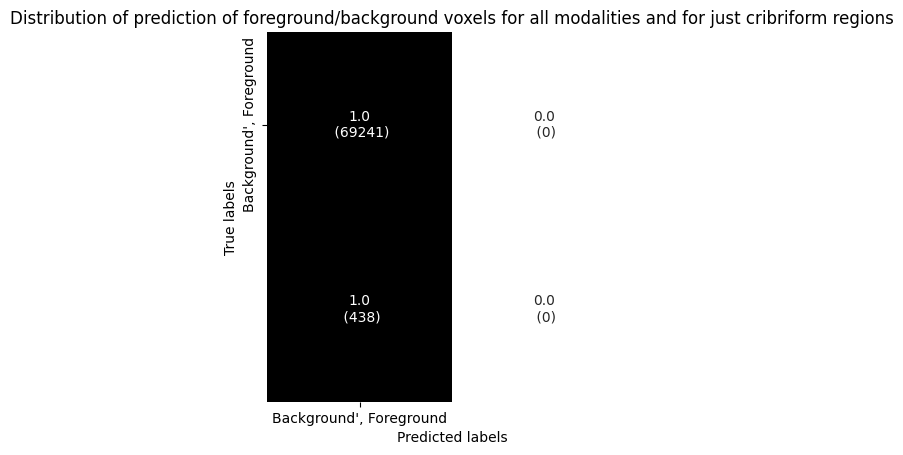

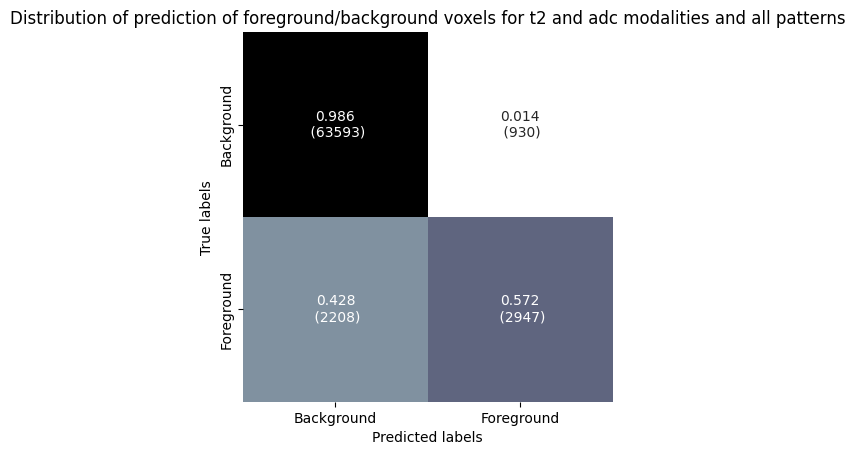

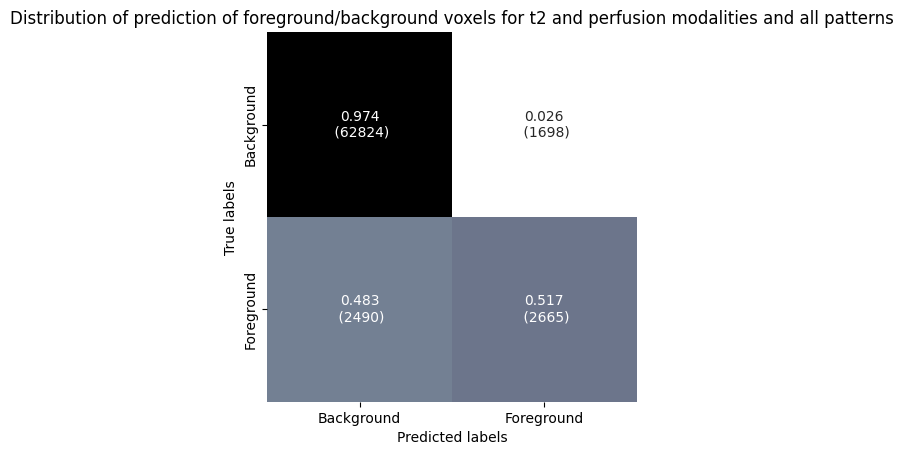

In [7]:
cm_label_tuples = [
    (all_modalities_cm, ["Background", "GG3", "GG4", "Cribriform"],
        "Distribution of prediction of voxels for all modalities and all patterns"),
    (gg3gg4_combined_cm, ["Background", "GG3 or GG4", "Cribriform"],
        "Distribution of prediction of voxels for all modalities and cribriform vs other regions"),
    (cribriform_only_cm, ["Background", "Cribriform"],
        "Distribution of prediction of voxels for all modalities and for just cribriform regions"),
    (adc_only_cm, ["Background", "GG3", "GG4", "Cribriform"],
        "Distribution of prediction of voxels for t2 and adc modalities and all patterns"),
    (perf_only_cm, ["Background", "GG3", "GG4", "Cribriform"],
        "Distribution of prediction of voxels for t2 and perfusion modalities and all patterns"),
    (all_modalities_cm_foreground_background, ["Background", "Foreground"],
        "Distribution of prediction of foreground/background voxels for all modalities and all patterns"),
    (gg3gg4_combined_cm_foreground_background, ["Background", "Foreground"],
        "Distribution of prediction of foreground/background voxels for all modalities and cribriform vs other regions"),
    (cribriform_only_cm_foreground_background, ["Background", "Foreground"],
        "Distribution of prediction of foreground/background voxels for all modalities and for just cribriform regions"),
    (adc_only_cm_foreground_background, ["Background", "Foreground"],
        "Distribution of prediction of foreground/background voxels for t2 and adc modalities and all patterns"),
    (perf_only_cm_foreground_background, ["Background", "Foreground"],
        "Distribution of prediction of foreground/background voxels for t2 and perfusion modalities and all patterns"),
    
]

for cm, labels, description in cm_label_tuples:
    # print(cm, labels)
    normalized_cm, annotations = normalize_and_create_annotations(cm)
    sns.heatmap(normalized_cm,
                xticklabels = labels,
                yticklabels = labels,
                annot = annotations,
                fmt = '',
                cbar = False,
                square = True,
                cmap = "bone_r")

    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title(f"{description}")

    plt.show()